## XGBoost Model

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import pickle
pd.options.mode.chained_assignment = None

from _util.custom_plotting import corr_heatmap, histogram_boxplot, horizontal_bar, heatmap_boxplot, simple_bar
from _util.make_confusion_matrix import make_cm
from _util.model_comparisons import *
from _util.custom_mem_opt import custom_mem_opt

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [5]:
root = './_pkls/'
df = pd.read_pickle(root + 'final_data.p')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [7]:
df = custom_mem_opt(df)

Memory usage of properties dataframe is : 4283.495386123657  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1204.2280359268188  MB
This is  28.11320959578722 % of the initial size


In [8]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [9]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [10]:
print(df.shape)

(8474661, 68)


In [26]:
df_red, df_val = train_test_split(df, test_size=0.3, stratify=df['reordered'])
#df_red = df.groupby('reordered', group_keys=False).apply(lambda x: x.sample(frac=0.3))

In [30]:
y_val = df_val.reordered
X_val = df_val.drop(["reordered", 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
print(X_val.shape)

(2542399, 64)


In [31]:
y_red = df_red.reordered
X_red = df_red.drop(["reordered", 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
print(X_red.shape)

(5932262, 64)


In [32]:
y = df.reordered
X = df.drop(["reordered", 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis = 1)
print(X.shape)

(8474661, 64)


## Train-Test Split

In [60]:
#X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.3)
#X_train, X_test, y_train, y_test = train_test_split(X_val, y_val, test_size = 0.3)
X_train, X_test, y_train, y_test = train_test_split(X_red, y_red, test_size = 0.3)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (4152583, 64)
Shape of y_train:  (4152583,)
Shape of X_test:  (1779679, 64)
Shape of y_test:  (1779679,)


In [61]:
print(y_train.value_counts())

reordered
0.0    3746523
1.0     406060
Name: count, dtype: int64


In [62]:
print(np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1]))

10.0


In [63]:
print(y_test.value_counts())

reordered
0.0    1605562
1.0     174117
Name: count, dtype: int64


### XGBoost

In [64]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
D_val = xgb.DMatrix(X_val, label=y_val)

In [65]:
xgb_params = {
    "objective"        :"reg:logistic",
    "eval_metric"      :"logloss",
    "eta"              :0.1,
    "max_depth"        :6,
    "min_child_weight" :10,
    "gamma"            :0.70,
    "subsample"        :0.76,
    "colsample_bytree" :0.95,
    "alpha"            :2e-05,
    "scale_pos_weight" :10,
    "lambda"           :10
}

In [66]:
watchlist= [(D_train, "train")]
start = time.perf_counter()
model = xgb.train(params=xgb_params, dtrain=D_train, num_boost_round = 80, evals = watchlist, verbose_eval = 10)
end = time.perf_counter()

[0]	train-logloss:0.69500
[10]	train-logloss:0.56454
[20]	train-logloss:0.53817
[30]	train-logloss:0.53096
[40]	train-logloss:0.52838
[50]	train-logloss:0.52715
[60]	train-logloss:0.52626
[70]	train-logloss:0.52548
[79]	train-logloss:0.52510


In [67]:
probability = model.predict(D_train)
pred_train = [1 if i > 0.5 else 0 for i in probability]
probability = model.predict(D_test)
pred_test = [1 if i > 0.5 else 0 for i in probability]
probability = model.predict(D_val)
pred_val = [1 if i > 0.5 else 0 for i in probability]

In [68]:
samples_dict = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'y_val': y_val, 'X_val': X_val}
models_dict = {}

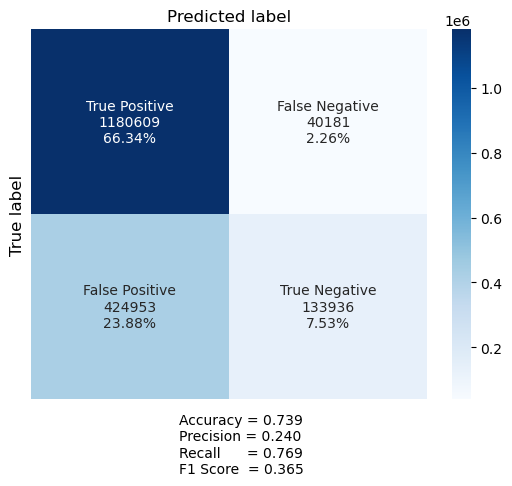

,Model,Conv. Time (sec.),Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1-Score,Test_F1-Score
0,XGBoost train/test,7.1665,0.739118,0.738642,0.770519,0.76923,0.240116,0.239647,0.366133,0.365443


In [69]:
samples_dict['pred_train'] = pred_train
samples_dict['pred_test'] = pred_test
samples_dict['pred_val'] = pred_val

# Compute and print the confusion matrix and classification report
#Creating confusion matrix
make_cm([y_test, pred_test])

#Models and sample dicts
models_dict['XGBoost train/test'] = {'pred_train':pred_train, 'pred_test':pred_test, 'est_time':end-start, 'validation':False}

#Print model comparisons
model_comparisons(models_dict, samples_dict)

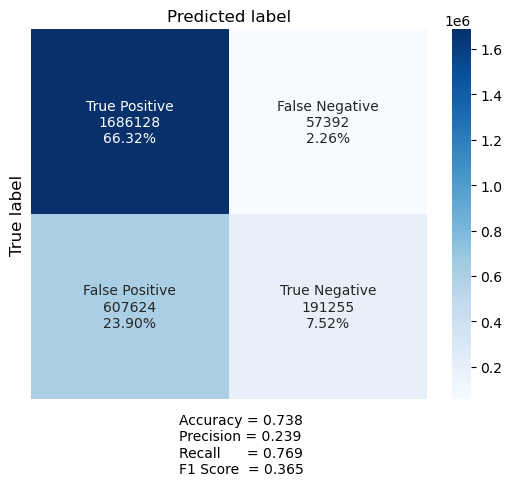

,Model,Conv. Time (sec.),Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1-Score,Test_F1-Score
0,XGBoost train/test,7.1665,0.739118,0.738642,0.770519,0.769230,0.240116,0.239647,0.366133,0.365443
1,XGBoost train/val,7.1665,0.739118,0.738430,0.770519,0.769183,0.240116,0.239404,0.366133,0.365156


In [71]:
# Compute and print the confusion matrix and classification report
#Creating confusion matrix
make_cm([y_val, pred_val])

#Models and sample dicts
models_dict['XGBoost train/val'] = {'pred_train':pred_train, 'pred_val':pred_val, 'est_time':end-start, 'validation':True}

#Print model comparisons
model_comparisons(models_dict, samples_dict)

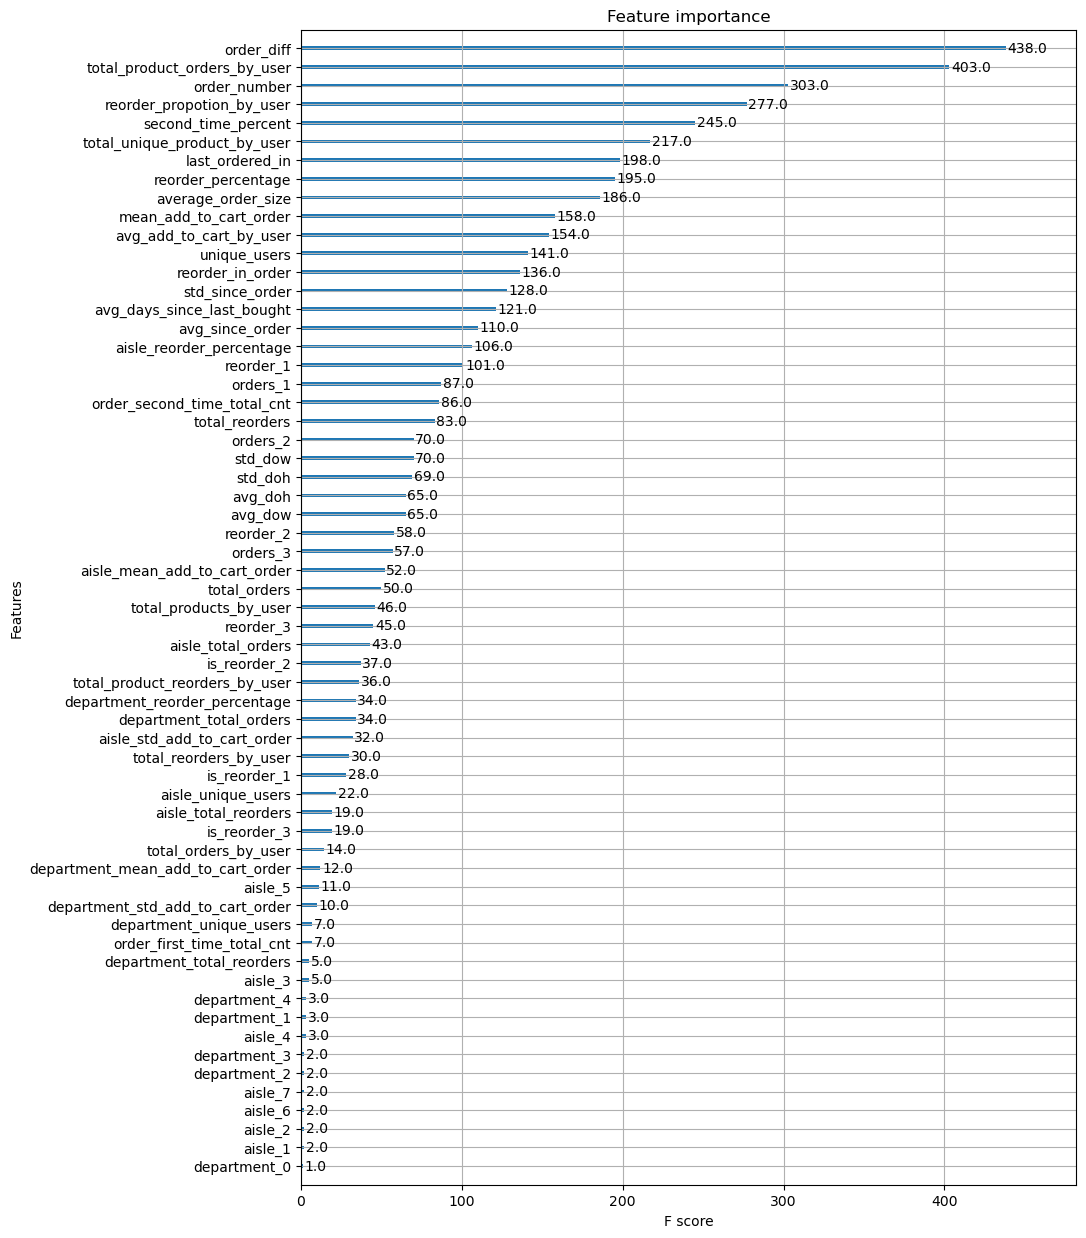

In [78]:
fig, ax = plt.subplots(figsize = (10,15))
ax = xgb.plot_importance(model, ax = ax)
fig.savefig('_plts/XGB Feature Imp.png')
fig.show()

In [73]:
## serialize model ##
pickle.dump(model, open('_pkls/xgb_model.p', 'wb'))